In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark
!pip install diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=48eb76c3b22be64371e6c220657afca204887816a9c1cfa783d435f6ec700511
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install pybloom_live

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Created wheel for pybloom_live: filename=pybloom_live-4.0.0-py3-none-any.whl size=9228 sha256=787578be2ffcf2babdf66a3181d781eab9a476146ab3e6d4c54d91c0f7352a4b
  Stored in directory: /root/.cache/pip/wheels/36/8a/9f/83ab00e9a9b2b10cec6135fa2a6cd92a22edf3d87fdaae481e
Successfully built pybloom_live


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import StructType, StructField, IntegerType,FloatType,DoubleType
from pyspark.sql import Row
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import seaborn as sns
from diffprivlib.mechanisms import Laplace
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pybloom_live import BloomFilter
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder,VectorAssembler

In [ ]:
# Initialize a Spark session
spark = SparkSession.builder.appName("Data Loading and Preprocessing").getOrCreate()
bloom = BloomFilter(capacity=500000, error_rate=0.01)


In [ ]:
def read_csv_with_spark(filename):
    # Load data into DataFrame
    df = spark.read.csv(filename, header=True, inferSchema=True)
    return df

def populate_bloom_filter(df, column_name):
    npi_list = df.select(column_name).distinct().rdd.flatMap(lambda x: x).collect()
    for npi in npi_list:
        bloom.add(npi)

In [ ]:
print("NOW LOADING")
print("leie.csv data!\n")
leie = read_csv_with_spark('/content/drive/MyDrive/TermProject/spark/leie.csv')
print("NOW LOADING")
print("medicare.csv data!\n")
med_main = read_csv_with_spark('/content/drive/MyDrive/TermProject/spark/meds.csv')
med_main = med_main.withColumnRenamed("Prescriber_NPI", "NPI")


NOW LOADING
leie.csv data!

NOW LOADING
medicare.csv data!

NOW LOADING
leie.csv data!

NOW LOADING
medicare.csv data!



In [ ]:
#populate_bloom_filter(leie, "NPI")
#populate_bloom_filter(med_main, "NPI")

print("NOW LOADING")
print("payment.csv data!\n")
payments = read_csv_with_spark('/content/drive/MyDrive/TermProject/spark/payment.csv')
payments = payments.withColumnRenamed("Physician_NPI", "NPI")
filtered_payments = payments.rdd.filter(lambda row: row.NPI not in bloom).toDF()


# Rename columns to unify 'NPI'
df_merged = leie.join(med_main, "NPI", how="outer")
df_merged = df_merged.join(filtered_payments, "NPI", how="outer")

NOW LOADING
payment.csv data!

NOW LOADING
payment.csv data!



In [ ]:
df_merged = leie.select("NPI", "EXCLTYPE", "EXCLDATE").join(
    med_main.select("NPI", "Total_Claims", "Total_Drug_Cost"),
    on="NPI",
    how="outer"
)

df_merged = df_merged.join(
    payments.select("NPI", "Total_Amount_Invested_USDollars", "Value_of_Interest"),
    on="NPI",
    how="outer"
)

# Fill NA values
df_merged = df_merged.na.fill({"EXCLTYPE": "No Exclusion"})

# Create a new column 'Category' based on the condition in 'EXCLTYPE'
df_merged = df_merged.withColumn(
    "Category",
    when(col("EXCLTYPE") != "No Exclusion", "Exceptions").otherwise("Non-Exceptions")
)

In [ ]:
df_merged = df_merged.withColumn("Total_Claims", col("Total_Claims").cast(DoubleType()))
df_merged = df_merged.withColumn("Total_Drug_Cost", col("Total_Drug_Cost").cast(DoubleType()))
df_merged = df_merged.withColumn("Total_Amount_Invested_USDollars", col("Total_Amount_Invested_USDollars").cast(DoubleType()))
df_merged = df_merged.withColumn("Value_of_Interest", col("Value_of_Interest").cast(DoubleType()))

# Fill NA values with zero
df_merged = df_merged.na.fill({
    "Total_Claims": 0,
    "Total_Drug_Cost": 0,
    "Total_Amount_Invested_USDollars": 0,
    "Value_of_Interest": 0
})

In [ ]:

df_merged = df_merged.withColumn("label", when(col("Category") == "Exceptions", 1).otherwise(0))

# Define features
features = ['Total_Claims', 'Total_Drug_Cost', 'Total_Amount_Invested_USDollars', 'Value_of_Interest']

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_merged = assembler.transform(df_merged)

# Split the data into training and test sets
train, test = df_merged.randomSplit([0.7, 0.3], seed=42)

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

pipeline = Pipeline(stages=[scaler])

# fitting scaler on train and test
model = pipeline.fit(train)
train = model.transform(train)
test = model.transform(test)

In [ ]:
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="label")
lr_model = lr.fit(train)

# Making predictions
predictions = lr_model.transform(test)

# Evaluating using AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("AUC of the model: ", auc)

AUC of the model:  0.9244151308914248


In [ ]:
category_counts = df_merged.groupBy("Category").count()
local_counts = category_counts.collect()

In [ ]:
#  a small use case of Differential Privacy
epsilon = 1.0
laplace_mechanism = Laplace(epsilon=epsilon, sensitivity=1)

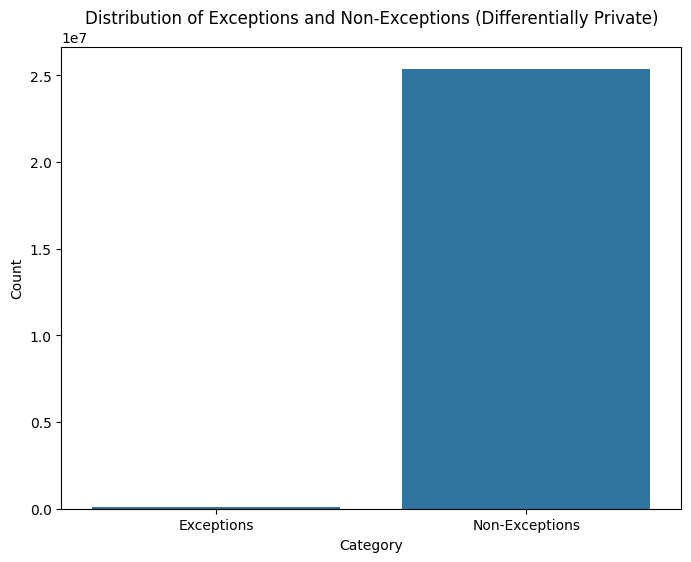

In [ ]:
dp_counts = {row['Category']: max(int(laplace_mechanism.randomise(row['count'])), 0) for row in local_counts}
categories, counts = zip(*dp_counts.items())

plt.figure(figsize=(8, 6))
sns.barplot(x=list(categories), y=list(counts))
plt.title('Distribution of Exceptions and Non-Exceptions (Differentially Private)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

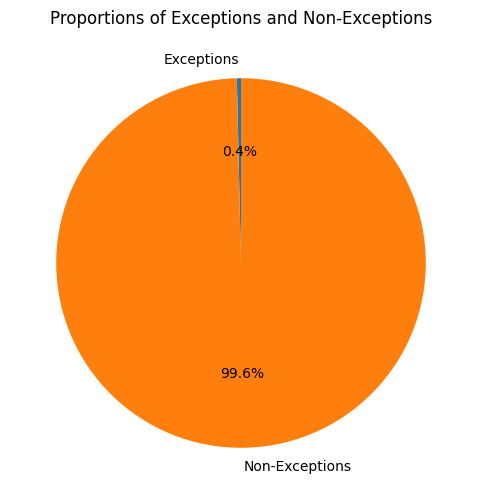

In [ ]:
category_counts = df_merged.groupBy("Category").count()
local_counts = category_counts.toPandas()

plt.figure(figsize=(8, 6))
local_counts.set_index('Category')['count'].plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Proportions of Exceptions and Non-Exceptions')
plt.ylabel('')  # Remove the y-label as it's unnecessary
plt.show()

In [ ]:
df_merged = df_merged.withColumn("EXCLTYPE", F.when(col("EXCLTYPE") == "Exceptions", 1).otherwise(0))

# One hot encoding EXCLTYPE
#indexer = StringIndexer(inputCol="EXCLTYPE", outputCol="EXCLTYPE_Index")
encoder = OneHotEncoder(inputCols=["EXCLTYPE"], outputCols=["EXCLTYPE_Encoded"])
pipeline = Pipeline(stages=[encoder])
df_merged = pipeline.fit(df_merged).transform(df_merged)

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType,FloatType,DoubleType
feature_cols = [col for col in df_merged.columns if df_merged.schema[col].dataType in [DoubleType(), FloatType(), IntegerType()]]
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=feature_cols, outputCol=vector_col)
df_vector = assembler.transform(df_merged).select(vector_col)

In [ ]:
from pyspark.ml.stat import Correlation
corr_matrix = Correlation.corr(df_vector, vector_col).head()[0].toArray()
corr_df = pd.DataFrame(corr_matrix, index=feature_cols, columns=feature_cols)

# Filtering by EXCLTYPE correlations and removing 'NPI' column
excltype_correlations = corr_df.filter(like='EXCLTYPE_')
if 'NPI' in excltype_correlations.columns:
    excltype_correlations = excltype_correlations.drop('NPI', axis=1)

# Plotting heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(excltype_correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap between Numerical Features and EXCLTYPE')
plt.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.ml.stat.Correlation.corr.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 566.0 failed 1 times, most recent failure: Lost task 1.0 in stage 566.0 (TID 961) (3e22cb42c6f9 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$3373/0x000000084141f040`: (struct<NPI_double_VectorAssembler_39d417879ad3:double,EXCLTYPE_double_VectorAssembler_39d417879ad3:double,Total_Claims:double,Total_Drug_Cost:double,Total_Amount_Invested_USDollars:double,Value_of_Interest:double,label_double_VectorAssembler_39d417879ad3:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.smj_consumeFullOuterJoinRow_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.wholestagecodegen_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 41 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1202)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1289)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1256)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1242)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1242)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computeCovariance(RowMatrix.scala:456)
	at org.apache.spark.mllib.stat.correlation.PearsonCorrelation$.computeCorrelationMatrix(PearsonCorrelation.scala:49)
	at org.apache.spark.mllib.stat.correlation.Correlations$.corrMatrix(Correlation.scala:66)
	at org.apache.spark.mllib.stat.Statistics$.corr(Statistics.scala:90)
	at org.apache.spark.ml.stat.Correlation$.corr(Correlation.scala:71)
	at org.apache.spark.ml.stat.Correlation.corr(Correlation.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$3373/0x000000084141f040`: (struct<NPI_double_VectorAssembler_39d417879ad3:double,EXCLTYPE_double_VectorAssembler_39d417879ad3:double,Total_Claims:double,Total_Drug_Cost:double,Total_Amount_Invested_USDollars:double,Value_of_Interest:double,label_double_VectorAssembler_39d417879ad3:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.smj_consumeFullOuterJoinRow_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.wholestagecodegen_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 41 more
